In [188]:
import os
!pip install scikit-learn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [209]:
from rasterio.warp import reproject, Resampling
from rasterio.transform import from_bounds
from rasterio.mask import mask
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import FancyArrowPatch, Patch
import os
import rasterio
import warnings
from sklearn.neighbors import NearestNeighbors
# from pykrige.ok import OrdinaryKriging
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
from shapely.geometry import box
from shapely.geometry import Point
from scipy.interpolate import griddata
from dbfread import DBF
warnings.filterwarnings('ignore')

DATA_DIR = Path("data")
RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)

TARGET_CRS = 'EPSG:32632'  # UTM 32N
resolution = 10  # meters
NODATA = -9999
saocom_files = list(DATA_DIR.glob("verona_v2*"))

CORINE_CLASSES = {
    111: "Continuous urban fabric",
    112: "Discontinuous urban fabric",
    121: "Industrial or commercial units",
    122: "Road and rail networks",
    123: "Port areas",
    124: "Airports",
    131: "Mineral extraction sites",
    132: "Dump sites",
    133: "Construction sites",
    141: "Green urban areas",
    142: "Sport and leisure facilities",
    211: "Non-irrigated arable land",
    212: "Permanently irrigated land",
    213: "Rice fields",
    221: "Vineyards",
    222: "Fruit trees and berry plantations",
    223: "Olive groves",
    231: "Pastures",
    241: "Annual crops with permanent crops",
    242: "Complex cultivation patterns",
    243: "Agriculture with natural vegetation",
    244: "Agro-forestry areas",
    311: "Broad-leaved forest",
    312: "Coniferous forest",
    313: "Mixed forest",
    321: "Natural grasslands",
    322: "Moors and heathland",
    323: "Sclerophyllous vegetation",
    324: "Transitional woodland-shrub",
    331: "Beaches, dunes, sands",
    332: "Bare rocks",
    333: "Sparsely vegetated areas",
    334: "Burnt areas",
    335: "Glaciers and perpetual snow",
    411: "Inland marshes",
    412: "Peat bogs",
    421: "Salt marshes",
    422: "Salines",
    423: "Intertidal flats",
    511: "Water courses",
    512: "Water bodies",
    521: "Coastal lagoons",
    522: "Estuaries",
    523: "Sea and ocean"
}
CORINE_COLORS = {
    # ARTIFICIAL SURFACES (1xx) - Red/Pink/Purple tones
    111: (230, 0, 77),      # Continuous urban fabric
    112: (255, 0, 0),       # Discontinuous urban fabric
    121: (204, 77, 242),    # Industrial or commercial units
    122: (204, 0, 0),       # Road and rail networks
    123: (230, 204, 204),   # Port areas
    124: (230, 204, 230),   # Airports
    131: (166, 0, 204),     # Mineral extraction sites
    132: (166, 77, 0),      # Dump sites
    133: (255, 77, 255),    # Construction sites
    141: (255, 166, 255),   # Green urban areas
    142: (255, 230, 255),   # Sport and leisure facilities

    # AGRICULTURAL AREAS (2xx) - Yellow/Brown tones
    211: (255, 255, 168),   # Non-irrigated arable land
    212: (255, 255, 0),     # Permanently irrigated land
    213: (230, 230, 0),     # Rice fields
    221: (230, 128, 0),     # Vineyards
    222: (242, 166, 77),    # Fruit trees and berry plantations
    223: (230, 166, 0),     # Olive groves
    231: (230, 230, 77),    # Pastures
    241: (255, 230, 166),   # Annual crops with permanent crops
    242: (255, 230, 77),    # Complex cultivation patterns
    243: (230, 204, 77),    # Agriculture with natural vegetation
    244: (242, 204, 166),   # Agro-forestry areas

    # FOREST AND SEMI NATURAL AREAS (3xx) - Green tones
    311: (128, 255, 0),     # Broad-leaved forest
    312: (0, 166, 0),       # Coniferous forest
    313: (77, 255, 0),      # Mixed forest
    321: (204, 242, 77),    # Natural grasslands
    322: (166, 230, 77),    # Moors and heathland
    323: (166, 166, 230),   # Sclerophyllous vegetation
    324: (0, 204, 0),       # Transitional woodland-shrub
    331: (240, 240, 240),   # Beaches, dunes, sands
    332: (204, 204, 204),   # Bare rocks
    333: (204, 255, 204),   # Sparsely vegetated areas
    334: (0, 0, 0),         # Burnt areas
    335: (166, 230, 204),   # Glaciers and perpetual snow

    # WETLANDS (4xx) - Blue/Cyan tones
    411: (166, 166, 255),   # Inland marshes
    412: (77, 77, 255),     # Peat bogs
    421: (204, 204, 255),   # Salt marshes
    422: (230, 230, 255),   # Salines
    423: (166, 166, 230),   # Intertidal flats

    # WATER BODIES (5xx) - Dark blue tones
    511: (0, 204, 242),     # Water courses
    512: (128, 242, 230),   # Water bodies
    521: (0, 255, 166),     # Coastal lagoons
    522: (166, 255, 230),   # Estuaries
    523: (230, 242, 255)    # Sea and ocean
}

# Convert RGB (0-255) to RGB (0-1) for matplotlib
CORINE_COLORS_MPL = {k: (r/255, g/255, b/255) for k, (r, g, b) in CORINE_COLORS.items()}

In [190]:
def data_process_tiff(tiff_path):
    with rasterio.open(tiff_path) as src:
        # --- 1. View Metadata ---
        print("--- Metadata ---")
        print(f"Coordinate Reference System (CRS): {src.crs}")
        print(f"Dimensions: {src.width} x {src.height}")
        print(f"Number of bands: {src.count}")
        print(f"Data type: {src.dtypes[0]}")
        print(f"NoData value: {src.nodata}\n")

        # --- 2. Read the pixel data from the first band ---
        # The result 'data' is a 2D NumPy array
        data = src.read(1)

        # --- 3. View the Data ---
        print("--- Pixel Data ---")

        # Print the top-left 5x5 corner of the array
        print("Top-left corner values:")
        print(data[:5, :5])

        # Print summary statistics
        # Use np.nanmin/nanmax if your nodata values are set to np.nan
        print("\n--- Statistics ---")
        print(f"Minimum value: {np.min(data)}")
        print(f"Maximum value: {np.max(data)}")
        print(f"Mean value: {np.mean(data):.2f}")

        # For categorical data, viewing unique values is very helpful
        unique_values, counts = np.unique(data, return_counts=True)
        print(f"\nFound {len(unique_values)} unique values.")
        # Print the top 10 most common values
        sorted_indices = np.argsort(-counts)
        print("Top 10 unique values (value: count):")
        for i in sorted_indices[:10]:
            print(f"  {unique_values[i]}: {counts[i]}")

Tiff Display

In [210]:
# def show_tiff(tiff_path, cmap='terrain'):
#     """Display a single TIFF in Jupyter"""
#     with rasterio.open(tiff_path) as src:
#         data = src.read(1).astype(float)
#         if src.nodata is not None:
#             data[data == src.nodata] = np.nan
#
#         plt.figure(figsize=(10, 8))
#         plt.imshow(data, cmap=cmap)
#         plt.colorbar(label='Height (m)')
#         plt.title(Path(tiff_path).stem)
#         plt.axis('off')
#         plt.show()

# def show_tiff_pts_2(tiff_path, pts=None, cmap='terrain', pt_color='red', pt_size=1):
#     """Display a TIFF with optional points overlay"""
#     with rasterio.open(tiff_path) as src:
#         data = src.read(1).astype(float)
#         if src.nodata is not None:
#             data[data == src.nodata] = np.nan
#
#         plt.figure(figsize=(10, 8))
#         plt.imshow(data, cmap=cmap, extent=[src.bounds.left, src.bounds.right,
#                                            src.bounds.bottom, src.bounds.top])
#
#         # Overlay points if provided
#         if pts is not None and len(pts) > 0:
#             # Reproject points to match raster CRS if needed
#             if pts.crs != src.crs:
#                 pts_proj = pts.to_crs(src.crs)
#             else:
#                 pts_proj = pts
#
#             plt.scatter(pts_proj.geometry.x, pts_proj.geometry.y,
#                        c=pt_color, s=pt_size, alpha=0.7, edgecolors='none')
#             print(f"Displayed {len(pts)} points")
#
#         plt.colorbar(label='Height (m)')
#         plt.title(Path(tiff_path).stem)
#         plt.xlabel('X (m)')
#         plt.ylabel('Y (m)')
#         plt.show()



def show_tiff_pts(tiff_path, pts=None, categorical=False, class_labels=None,
                 cmap='terrain', pt_color='red', pt_size=1):
    """
    Display a TIFF with optional points overlay.
    Handles both continuous and categorical rasters with improved visualization.
    Automatically uses CORINE colors if CORINE_NAMES/CORINE_COLORS_MPL are available.

    Args:
        tiff_path (str or Path): Path to the TIFF file
        pts (GeoDataFrame, optional): GeoDataFrame of points to overlay
        categorical (bool): True for discrete data, False for continuous
        class_labels (dict, optional): Mapping of codes to names {code: 'name'}
        cmap (str): Matplotlib colormap name
        pt_color (str): Color for overlay points
        pt_size (int): Size for overlay points
    """
    with rasterio.open(tiff_path) as src:
        data = src.read(1).astype(float)
        if src.nodata is not None:
            data[data == src.nodata] = np.nan

        # Get coordinate bounds
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

        #

        if categorical:
            # === START: NEW CATEGORICAL BLOCK ===

            # 1. Setup a multi-panel plot for the map and bar chart
            fig, (ax_map, ax_bar) = plt.subplots(1, 2, figsize=(20, 10),
                                                gridspec_kw={'width_ratios': [2, 1]})

            # --- Calculate Statistics and Create DataFrame ---
            valid_data = data[~np.isnan(data)]
            if len(valid_data) == 0:
                print("No valid data found to plot.")
                plt.close(fig) # Close the empty figure
                return

            unique_vals, counts = np.unique(valid_data, return_counts=True)

            stats = []
            for code, count in zip(unique_vals, counts):
                code = int(code)
                color = (0.5, 0.5, 0.5) # Default gray
                if 'CORINE_COLORS_MPL' in globals() and code in CORINE_COLORS_MPL:
                    color = CORINE_COLORS_MPL[code]

                stats.append({
                    'code': code,
                    'name': class_labels.get(code, f'Unknown ({code})') if class_labels else f'Class {code}',
                    'count': count,
                    'area_km2': (count * src.res[0] * src.res[1]) / 1_000_000,
                    'color': color
                })
            df = pd.DataFrame(stats).sort_values('area_km2', ascending=False).reset_index(drop=True)

            # --- Plot 1: The Map ---
            plot_codes = df['code'].tolist()
            plot_colors = df['color'].tolist()
            custom_cmap = mcolors.ListedColormap(plot_colors)
            bounds = np.array(plot_codes + [max(plot_codes) + 1]) - 0.5
            norm = mcolors.BoundaryNorm(bounds, len(plot_colors))

            ax_map.imshow(data, cmap=custom_cmap, norm=norm, extent=extent, interpolation='nearest')

            # --- Plot 2: The Statistics Bar Chart ---
            top_n = 12 # Show the top 12 classes in the chart
            df_plot = df.head(top_n)
            df_plot_sorted = df_plot.sort_values('area_km2', ascending=True)

            ax_bar.barh(df_plot_sorted['name'], df_plot_sorted['area_km2'], color=df_plot_sorted['color'])
            ax_bar.set_title('Top Land Cover Classes', fontsize=12)
            ax_bar.set_xlabel('Area (km²)')

            # --- Final Formatting for Both Plots ---
            # Set the map as the primary axis for subsequent point overlays and formatting
            ax = ax_map

            # Create a legend for the map
            legend_handles = [Patch(facecolor=row['color'], label=f"{row['name']}") for index, row in df_plot.iterrows()]
            ax.legend(handles=legend_handles, title='Top Classes', bbox_to_anchor=(1.02, 1), loc='upper left')

            # === END: NEW CATEGORICAL BLOCK ===

        else:
            fig, ax = plt.subplots(figsize=(14, 10))

            # For continuous data, use actual data range
            valid_data = data[~np.isnan(data)]
            if len(valid_data) == 0:
                print("No valid data found to plot.")
                return

            vmin, vmax = np.min(valid_data), np.max(valid_data)

            im = ax.imshow(data, cmap=cmap, extent=extent, vmin=vmin, vmax=vmax)
            cbar = fig.colorbar(im, ax=ax, shrink=0.8, pad=0.02)
            cbar.set_label('Elevation (m)', fontsize=12)


        # Overlay points if provided
        if pts is not None and len(pts) > 0:
            if pts.crs != src.crs:
                pts_proj = pts.to_crs(src.crs)
            else:
                pts_proj = pts

            ax.scatter(pts_proj.geometry.x, pts_proj.geometry.y,
                      c=pt_color, s=pt_size, alpha=0.7, edgecolors='black',
                      linewidths=0.1, zorder=10)


        # Format coordinate axes
        ax.ticklabel_format(style='plain', axis='both')

        # Set proper axis labels based on CRS

        ax.set_xlabel('Easting (m)', fontsize=12)
        ax.set_ylabel('Northing (m)', fontsize=12)


        # Format tick labels for better readability
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f'{int(y):,}'))

        # Rotate x-axis labels if they're too long
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

        # Add north arrow
        add_north_arrow(ax, extent)

        # Set title and improve layout
        ax.set_title(Path(tiff_path).stem, fontsize=14, fontweight='bold', pad=20)
        ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

        plt.tight_layout()
        plt.show()

def add_north_arrow(ax, extent, size=0.05, pad=0.1):
    """
    Add a north arrow to the plot

    Args:
        ax: matplotlib axes object
        extent: [xmin, xmax, ymin, ymax] of the plot
        size: Size of the arrow as fraction of plot width
        pad: Padding from edges as fraction of plot dimensions
    """
    # Calculate position (top-right corner with padding)
    width = extent[1] - extent[0]
    height = extent[3] - extent[2]

    arrow_x = extent[1] - pad * width
    arrow_y = extent[3] - pad * height

    arrow_length = size * min(width, height)

    # Create north arrow
    arrow = FancyArrowPatch(
        (arrow_x, arrow_y - arrow_length/2),
        (arrow_x, arrow_y + arrow_length/2),
        arrowstyle='->,head_length=0.3,head_width=0.15',
        color='black',
        linewidth=2,
        zorder=1000
    )
    ax.add_patch(arrow)

    # Add "N" label
    ax.text(arrow_x, arrow_y + arrow_length/2 + arrow_length*0.2, 'N',
            horizontalalignment='center', verticalalignment='bottom',
            fontsize=12, fontweight='bold', zorder=1000)

    # Add background circle for better visibility
    circle = plt.Circle((arrow_x, arrow_y), arrow_length*0.6,
                       color='white', alpha=0.8, zorder=999)
    ax.add_patch(circle)


Tiff Inspection

In [192]:
def inspect_tiff(tiff_path):
    """Comprehensive inspection of TIFF file contents"""

    print(f"🔍 INSPECTING: {Path(tiff_path).name}")
    print("="*60)

    with rasterio.open(tiff_path) as src:
        # Basic file info
        print(f"📋 BASIC INFO:")
        print(f"  Dimensions: {src.width} x {src.height}")
        print(f"  Bands: {src.count}")
        print(f"  Data types: {src.dtypes}")
        print(f"  CRS: {src.crs}")
        print(f"  Resolution: {src.res}")
        print(f"  Bounds: {src.bounds}")
        print(f"  NoData: {src.nodata}")

        # Metadata
        print(f"\n📝 METADATA:")
        if src.tags():
            for key, value in src.tags().items():
                print(f"  {key}: {value}")
        else:
            print("  No metadata found")

        # Band descriptions
        print(f"\n📊 BAND INFORMATION:")
        for i in range(1, src.count + 1):
            print(f"\n  BAND {i}:")

            # Band metadata
            band_tags = src.tags(i)
            if band_tags:
                for key, value in band_tags.items():
                    print(f"    {key}: {value}")

            # Read sample data
            data = src.read(i)

            # Handle nodata
            if src.nodata is not None:
                valid_data = data[data != src.nodata]
            else:
                valid_data = data.flatten()

            if len(valid_data) > 0:
                print(f"    Data type: {data.dtype}")
                print(f"    Valid pixels: {len(valid_data):,} / {data.size:,} ({len(valid_data)/data.size*100:.1f}%)")
                print(f"    Range: {valid_data.min():.3f} to {valid_data.max():.3f}")
                print(f"    Mean: {valid_data.mean():.3f}")
                print(f"    Std: {valid_data.std():.3f}")

                # Check for common LiDAR data patterns
                unique_vals = np.unique(valid_data)
                if len(unique_vals) < 20:
                    print(f"    Unique values: {unique_vals}")
                    print(f"    → Likely classification/categorical data")
                elif valid_data.max() < 100:
                    print(f"    → Possibly intensity, return info, or relative heights")
                elif 100 <= valid_data.max() < 5000:
                    print(f"    → Likely elevation data (meters)")
                else:
                    print(f"    → Possibly elevation in different units")
            else:
                print(f"    No valid data found")

        # Color interpretation (if available)
        print(f"\n🎨 COLOR INTERPRETATION:")
        for i in range(1, src.count + 1):
            color_interp = src.colorinterp[i-1]
            print(f"  Band {i}: {color_interp}")

        # Overviews
        print(f"\n🔍 OVERVIEWS:")
        for i in range(1, src.count + 1):
            overviews = src.overviews(i)
            if overviews:
                print(f"  Band {i}: {len(overviews)} overview levels")
            else:
                print(f"  Band {i}: No overviews")

Process Initiation

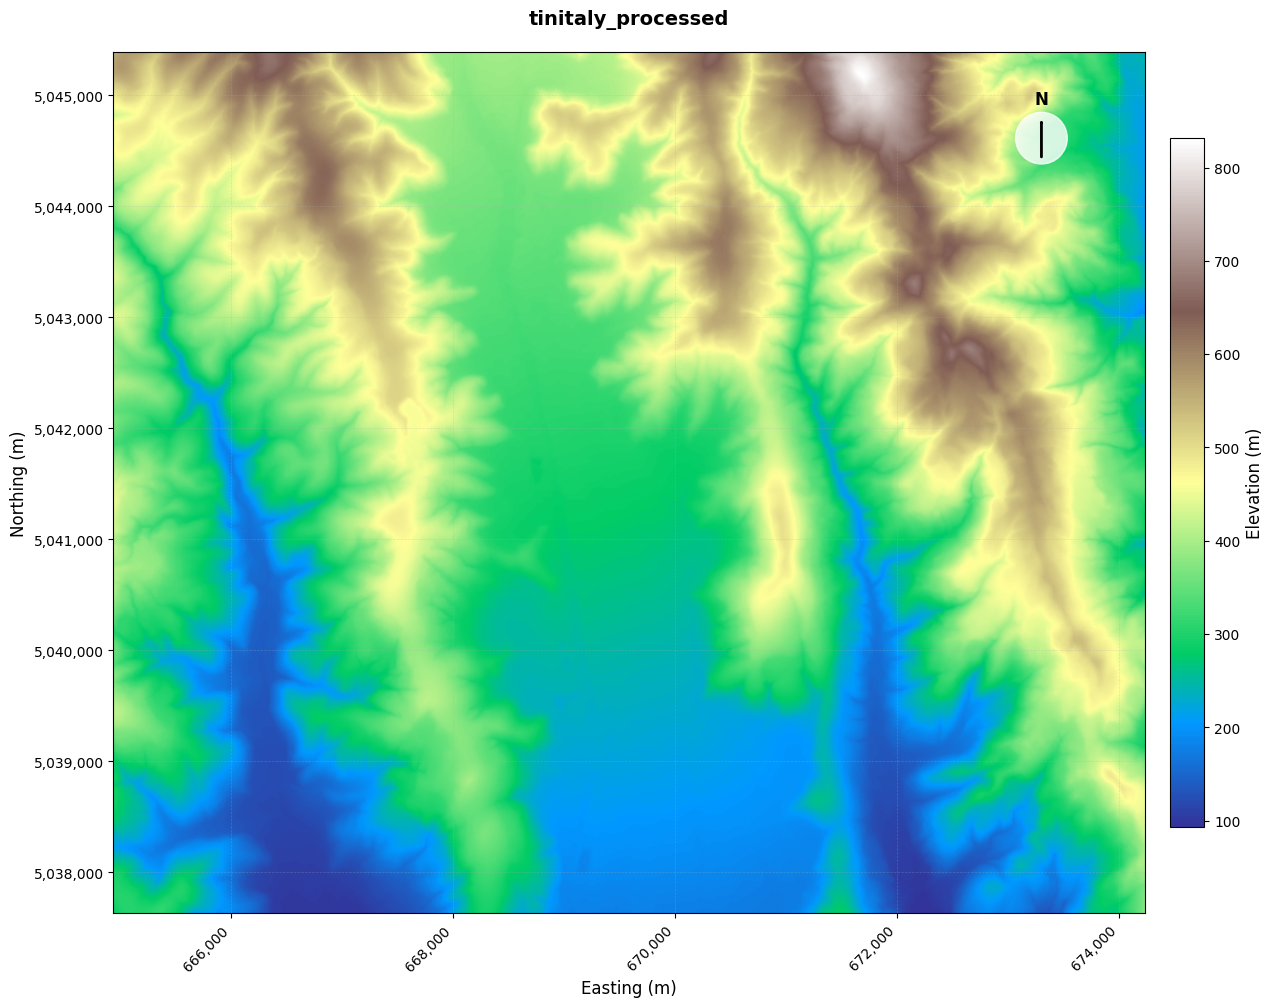

  -> Saved to results\tinitaly_processed.tif


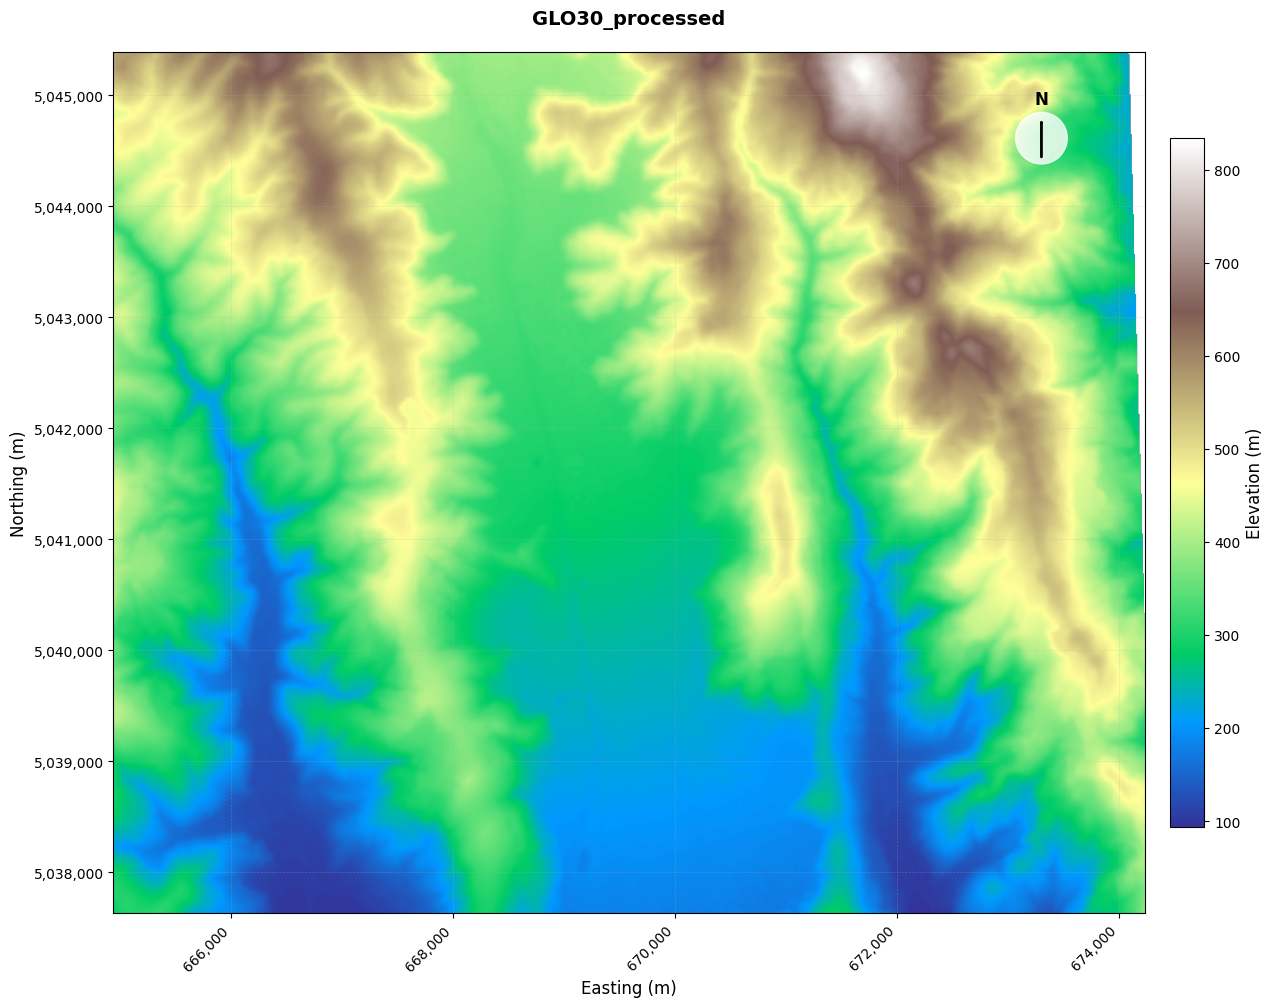

  -> Saved to results\GLO30_processed.tif
dbf file found
{'tinitaly': WindowsPath('results/tinitaly_processed.tif'), 'copernicus': WindowsPath('results/GLO30_processed.tif')}


In [211]:
def load_corine_data(tiff_path, file_name):
    vat_dbf_path_list = list(DATA_DIR.glob(f"{file_name}.tif.vat.dbf"))
    # Check if the list is not empty before trying to access the first element
    if not vat_dbf_path_list:
        print(f"Error: .dbf file not found for {file_name}.")
        return None
    else:
        print('dbf file found')
    vat_dbf_path = vat_dbf_path_list[0]

    # Pass the single Path object to DBF()
    dbf_table = DBF(vat_dbf_path, load=True)
    # Create a dictionary for quick lookups
    classification_lookup = {}

    try:
        for record in dbf_table.records:
            value = record['Value']
            label = record['LABEL3']
            classification_lookup[value] = label
    except KeyError as e:
        print(f"Error: Missing field {e} in the .dbf file. Please check the field names.")


def process_reference_dem(dem_path, target_transform, target_width, target_height):
    """
    Reprojects and resamples a raster to a target grid.

    It intelligently chooses the resampling method:
    - Nearest Neighbor for categorical data (like CORINE).
    - Cubic Convolution for continuous data (like DEMs).
    """
    output_path = RESULTS_DIR / f"{dem_path.stem}_processed.tif"

    with rasterio.open(dem_path) as src:
        # 1. Set default parameters for continuous data (DEMs)
        resampling_method = Resampling.cubic
        output_dtype = 'float32'
        nodata = -9999
        # 2. Check if it's a CORINE file and override parameters
        if 'corine' in dem_path.name.lower() or 'lclu' in dem_path.name.lower():
            data = src.read(1)
            unique_vals = np.unique(data)
            resampling_method = Resampling.nearest
            # Use the original integer datatype to preserve whole numbers
            output_dtype = src.profile.get('dtype', 'uint8')
            nodata = 0
        # 3. Setup the output profile with the correct parameters
        profile = {
            'driver': 'GTiff',
            'dtype': output_dtype, # Use the selected data type
            'width': target_width,
            'height': target_height,
            'count': 1,
            'crs': TARGET_CRS,
            'transform': target_transform,
            'nodata': nodata # It's best to preserve the original nodata value
        }

        # Create the output array with the correct datatype and nodata value
        output_array = np.full((target_height, target_width), profile['nodata'], dtype=output_dtype)

        # 4. Reproject using the dynamically chosen resampling method
        reproject(
            source=rasterio.band(src, 1),
            destination=output_array,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=target_transform,
            dst_crs=TARGET_CRS,
            resampling=resampling_method, # Use the selected method
            src_nodata=src.nodata,
            dst_nodata=profile['nodata']
        )

        # Save the result
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(output_array, 1)
    if 'corine' in dem_path.name.lower() or 'lclu' in dem_path.name.lower():
        show_tiff_pts(
        output_path,
        categorical=True,          # <-- Tell the function it's categorical
        class_labels=CORINE_CLASSES # <-- Provide the class names for the legend
)
    else:
        show_tiff_pts(output_path, cmap='terrain')
    print(f"  -> Saved to {output_path}")
    return output_path

reference_dems = {}
# if 'saocom_grid' in locals():
    # Get target grid from SAOCOM
bounds = [grid_x.min(), grid_y.min(), grid_x.max(), grid_y.max()]
transform = from_bounds(*bounds, grid_x.shape[1], grid_x.shape[0])

# Find and process reference DEMs
dem_patterns = {
    'tinitaly': '*tinitaly*',
    'copernicus': '*GLO30*',
    'corine_clip': '*corine*'}
    # 'lclu_crop': '*lclu*'
# }

for name, pattern in dem_patterns.items():
    # Find the first matching file
    dem_files = list(DATA_DIR.glob(f"{pattern}.tif")) + list(DATA_DIR.glob(f"{pattern}.TIF"))

    if dem_files:
        if 'corine' in name.lower() or 'lclu' in name.lower():

            load_corine_data(dem_files[0], name)
        else:
            processed_path = process_reference_dem(
                dem_files[0], transform, grid_x.shape[1], grid_x.shape[0]
            )
            reference_dems[name] = processed_path


print(reference_dems)
# create_qaqc_report(gdf, cleaned_points, RESULTS_DIR)

|SAOCOM QA

In [194]:

def clean_bad_saocom_points(points_gdf, neighbor_distance=250, height_threshold=100):
    """
    Remove obvious bad points - like -300m in area where everything is ~200m
    """
    print(f"Cleaning: Starting with {len(points_gdf)} points")

    if len(points_gdf) < 10:
        return points_gdf

    # Find neighbors within distance
    coords = np.column_stack([points_gdf['x'], points_gdf['y']])
    heights = points_gdf['height'].values

    nbrs = NearestNeighbors(radius=neighbor_distance).fit(coords)
    OK = OrdinaryKriging(points_gdf['x'], points_gdf['y'], points_gdf['height'],
                         variogram_model='power',  # or 'gaussian', 'exponential'
                        enable_plotting=False,
                        coordinates_type='euclidean'
)
    print(OK)
    bad_points = []

    for i, (x, y, height) in enumerate(zip(points_gdf['x'], points_gdf['y'], heights)):
        # Find neighbors within radius
        neighbor_indices = nbrs.radius_neighbors([[x, y]], return_distance=False)[0]
        neighbor_indices = neighbor_indices[neighbor_indices != i]  # Remove self

        if len(neighbor_indices) < 3:  # Need at least 3 neighbors
            continue

        neighbor_heights = heights[neighbor_indices]
        neighbor_median = np.median(neighbor_heights)

        # Check if point is way off from neighbors
        height_diff = abs(height - neighbor_median)

        if height_diff > height_threshold:
            bad_points.append(i)
            print(f"  Bad point: {height:.1f}m vs neighbors ~{neighbor_median:.1f}m (diff: {height_diff:.1f}m)")

    # Remove bad points
    if bad_points:
        clean_points = points_gdf.drop(points_gdf.index[bad_points])
        print(f"Removed {len(bad_points)} obviously bad points")
    else:
        clean_points = points_gdf
        print("No obviously bad points found")

    print(f"Final: {len(clean_points)} points")
    return clean_points

Initial Loading of SAOCOM Data

In [195]:
"""Load SAOCOM point data"""
# Try different separators

df = pd.read_csv(saocom_files[0], sep=',')
# Standardize column names
cols = df.columns.str.upper().str.strip()
mapping = {'LAT': 'lat', 'LON': 'lon', 'HEIGHT': 'height', 'COHER': 'coherence'}

for old, new in mapping.items():
    if old in cols:
        df = df.rename(columns={old: new})

# Clean data
for col in ['lat', 'lon', 'height', 'coherence']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna(subset=['lat', 'lon', 'height'])
df = df[df['coherence'] >= 0.3]  # Filter by coherence

# Convert to GeoDataFrame and reproject
geometry = [Point(lon, lat) for lon, lat in zip(df['lon'], df['lat'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
gdf = gdf.to_crs(TARGET_CRS)
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y
# gdf = qaqc_saocom_points(gdf, reference_dem_path=reference_dems['tinitaly'])
# gdf = clean_bad_saocom_points(gdf)


Read and convert SAOCOM to raster


In [196]:
def read_saocom_csv(csv_path, coherence_threshold=0.3):
    # Try to read CSV - handle different separators and formats

    columns = ['ID', 'SVET', 'LVET', 'LAT', 'LON', 'HEIGHT',
              'HEIGHT_WRT_DEM', 'SIGMA_HEIGHT', 'COHER']
    df = pd.read_csv(csv_path, sep=',', names=columns, skiprows=1)
    # Standardize column names (handle variations)
    column_mapping = {
        'LAT': 'LAT', 'LATITUDE': 'LAT', 'lat': 'LAT',
        'LON': 'LON', 'LONGITUDE': 'LON', 'lon': 'LON', 'LONG': 'LON',
        'HEIGHT': 'HEIGHT', 'ELEVATION': 'HEIGHT', 'ELEV': 'HEIGHT',
        'COHER': 'COHER', 'COHERENCE': 'COHER', 'COH': 'COHER'
    }

    # Clean column names and apply mapping
    df.columns = [col.strip().upper() for col in df.columns]
    df = df.rename(columns=column_mapping)

    # Convert to numeric
    for col in ['LAT', 'LON', 'HEIGHT', 'COHER']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Remove invalid points
    df = df.dropna(subset=['LAT', 'LON', 'HEIGHT'])
    df = df[(df['LAT'] != 0) & (df['LON'] != 0)]

    # Apply coherence filter if available
    if 'COHER' in df.columns:
        df = df[df['COHER'] >= coherence_threshold]

    # Create GeoDataFrame
    geometry = [Point(lon, lat) for lon, lat in zip(df['LON'], df['LAT'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')

    # Reproject to UTM 32N
    gdf_utm = gdf.to_crs('EPSG:32632')

    # Add UTM coordinates as columns
    gdf_utm['X'] = gdf_utm.geometry.x
    gdf_utm['Y'] = gdf_utm.geometry.y

    return gdf_utm

def points_to_raster(gdf, resolution=10, method='linear'):
    # Get bounds from the GeoDataFrame
    bounds = gdf.total_bounds
    xmin, ymin, xmax, ymax = bounds

    # Create grid using np.arange
    x = np.arange(xmin, xmax + resolution, resolution)
    y = np.arange(ymax, ymin - resolution, -resolution)
    grid_x, grid_y = np.meshgrid(x, y)

    # Extract point coordinates and values
    points = np.column_stack((gdf['X'].values, gdf['Y'].values))
    values = gdf['HEIGHT'].values

    # Interpolate
    grid_points = np.column_stack([grid_x.ravel(), grid_y.ravel()])
    grid_values = griddata(points, values, grid_points, method=method, fill_value=np.nan)
    raster_array = grid_values.reshape(grid_x.shape)

    # Create transform
    transform = from_bounds(xmin, ymin, xmax, ymax, len(x), len(y))
    return raster_array, transform, (xmin, ymin, xmax, ymax)


def save_raster(array, transform, output_path, crs='EPSG:32632', nodata=-99):
    # Replace NaN with nodata value
    array_out = array.copy()
    array_out[np.isnan(array_out)] = nodata

    # Write to file
    with rasterio.open(
        output_path, 'w',
        driver='GTiff',
        height=array.shape[0],
        width=array.shape[1],
        count=1,
        dtype=array.dtype,
        crs=crs,
        transform=transform,
        nodata=nodata,
        compress='lzw'
    ) as dst:
        dst.write(array_out, 1)


def main():
    """
    Main conversion workflow
    """
    # Configuration
    config = {
        'input_csv': 'data/verona_v2.csv',  # <--- CHANGE THIS TO YOUR CSV FILE PATH
        'output_dir': Path('results/saocom_raster'),
        'resolution': 10,  # meters
        'coherence_threshold': 0.3,
        'interpolation_method': 'cubic',  # 'linear', 'nearest', or 'cubic'
    }

    # Create output directory
    config['output_dir'].mkdir(parents=True, exist_ok=True)

    # Step 1: Read and project CSV data
    gdf = read_saocom_csv(
        config['input_csv'],
        coherence_threshold=config['coherence_threshold']
    )

    # Save projected points for reference
    points_output = config['output_dir'] / "saocom_points_utm32n.gpkg"
    gdf.to_file(points_output, driver="GPKG")

    # Step 2: Convert to raster
    raster_array, transform, bounds = points_to_raster(
        gdf,
        resolution=config['resolution'],
        method=config['interpolation_method']
    )

    # Step 3: Save raster
    raster_output = config['output_dir'] / f"saocom_dem_utm32n_{config['resolution']}m.tif"
    save_raster(raster_array, transform, raster_output)

    # Step 4: Create visualization

# This block executes the main function when the cell is run
main()


-562.0 1163.7 340.03835396984624 116.95752571347572


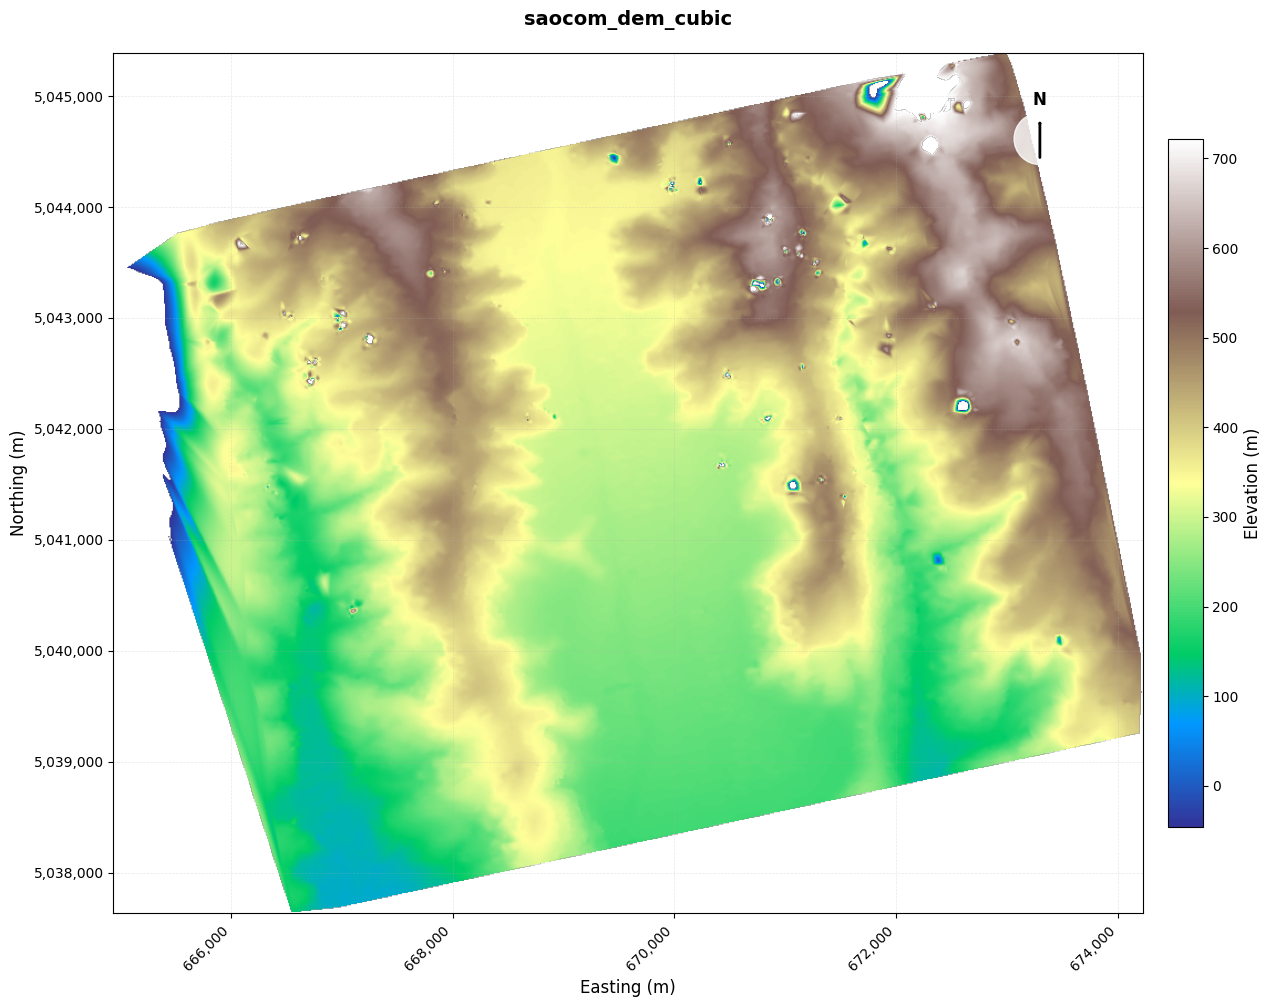

In [197]:
"""Convert points to regular grid"""
method = 'cubic'
# Define grid bounds
bounds = gdf.total_bounds
xmin, ymin, xmax, ymax = bounds

# Create grid
x = np.arange(xmin, xmax + resolution, resolution)
y = np.arange(ymax, ymin - resolution, -resolution)  # Flip Y direction
grid_x, grid_y = np.meshgrid(x, y)

# Interpolate
points_xy = np.column_stack([gdf['x'], gdf['y']])
values = gdf['height'].values
print(min(values), max(values), np.mean(values), np.std(values))
grid_points = np.column_stack([grid_x.ravel(), grid_y.ravel()])

grid_values = griddata(points_xy, values, grid_points, method=method, fill_value=NODATA)
lst_used = [i for i in grid_values if i != NODATA]
Q1 = np.percentile(lst_used, 25)
Q3 = np.percentile(lst_used, 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
grid_values = np.array([NODATA if i > upper_bound or i < lower_bound else i for i in grid_values])
# print(grid_values)
saocom_grid = grid_values.reshape(grid_x.shape)

# Save as GeoTIFF
transform = from_bounds(xmin, ymin, xmax, ymax, len(x), len(y))
saocom_raster_path = RESULTS_DIR / f"saocom_dem_{method}.tif"
with rasterio.open(saocom_raster_path, 'w', driver='GTiff', height=saocom_grid.shape[0],
                   width=saocom_grid.shape[1], count=1, dtype='float32',
                   crs=TARGET_CRS, transform=transform, nodata=NODATA) as dst:
    dst.write(saocom_grid.astype('float32'), 1)
show_tiff_pts(saocom_raster_path, cmap='terrain')



In [198]:

def calibrate_saocom(saocom_path, tinitaly_path):
    """Calibrate SAOCOM heights using TINITALY reference"""

    # Get SAOCOM bounds
    with rasterio.open(saocom_path) as src:
        saocom_bounds = src.bounds
        clip_geom = box(*saocom_bounds)

    # Clip TINITALY to SAOCOM extent
    with rasterio.open(tinitaly_path) as src:
        clipped_data, _ = rasterio.mask.mask(src, [clip_geom], crop=True)
        tinitaly_data = clipped_data[0]
        tinitaly_valid = tinitaly_data[(tinitaly_data != src.nodata) & (~np.isnan(tinitaly_data))]

    # Get SAOCOM average
    with rasterio.open(saocom_path) as src:
        saocom_data = src.read(1).astype(float)
        saocom_valid = saocom_data[(saocom_data != src.nodata) & (~np.isnan(saocom_data))]

    # Calculate bias and adjustment
    tinitaly_avg = np.mean(tinitaly_valid)
    saocom_avg = np.mean(saocom_valid)
    adjustment = tinitaly_avg - saocom_avg


    # Apply adjustment to SAOCOM
    with rasterio.open(saocom_path) as src:
        data = src.read(1).astype(np.float32)
        valid_mask = (data != src.nodata) & (~np.isnan(data))
        data[valid_mask] += adjustment

        # Save adjusted version
        output_path = Path(saocom_path).parent / f"{Path(saocom_path).stem}_calibrated.tif"
        profile = src.profile.copy()

        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(data, 1)

    print(f"Saved calibrated SAOCOM: {output_path.name}")
    return output_path

calibrated_saocom = calibrate_saocom(saocom_raster_path, reference_dems['tinitaly'])

Saved calibrated SAOCOM: saocom_dem_cubic_calibrated.tif


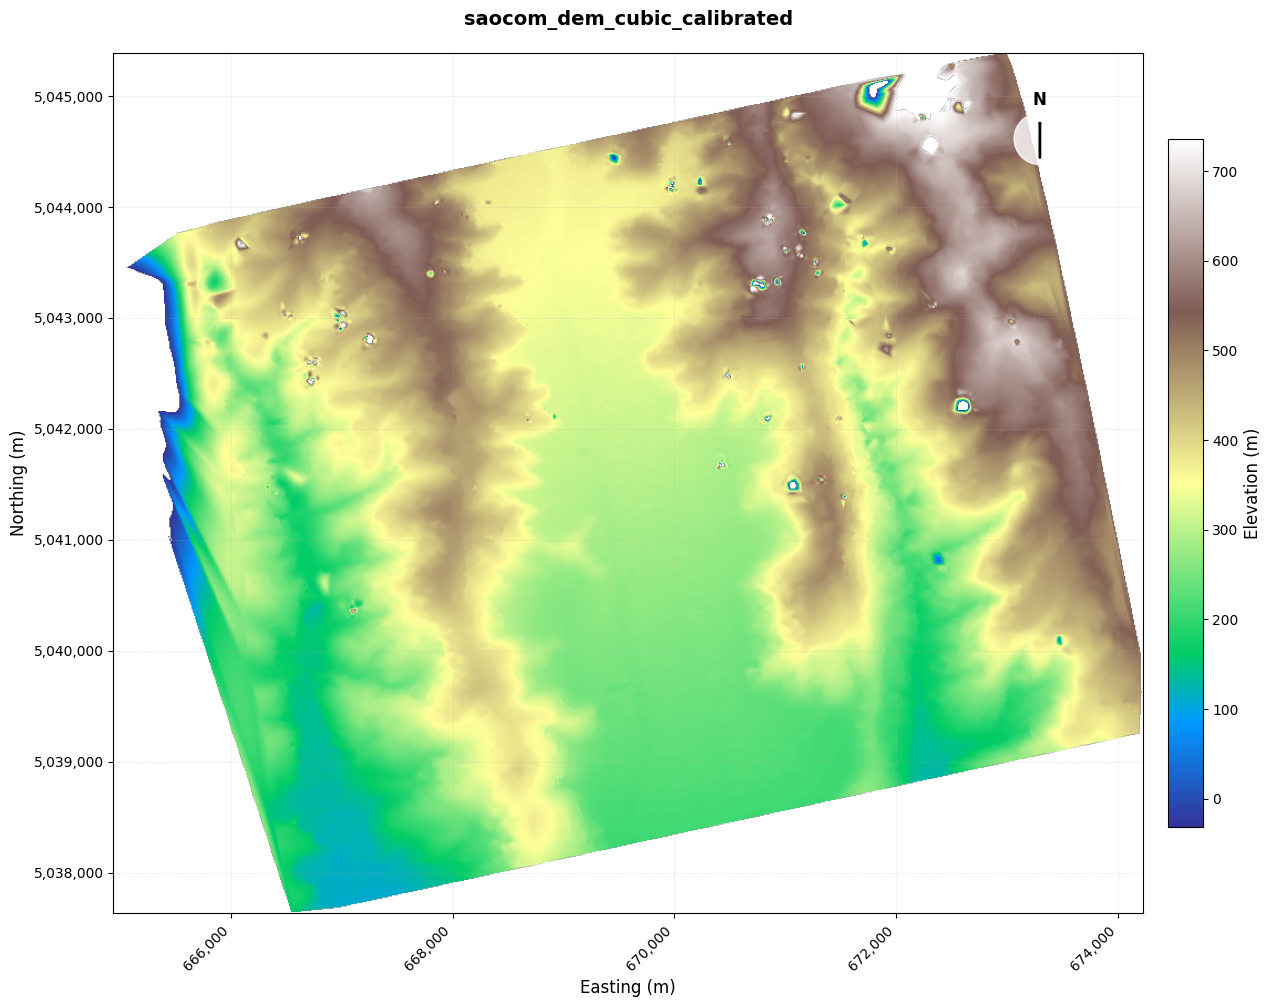

In [199]:
show_tiff_pts(calibrated_saocom)

Week 3 - QA/QC


In [200]:
# def quick_mask_raster(raster_path, gdf, coh_threshold=0.3):
#     """Apply coherence mask to raster"""
#
#     with rasterio.open(raster_path) as src:
#         data = src.read(1).astype(np.float32)
#         transform = src.transform
#         profile = src.profile.copy()
#
#         # Get low coherence points
#         low_coh = gdf[gdf['coherence'] < coh_threshold]
#
#         if len(low_coh) > 0:
#             # Convert to pixel coordinates
#             inv_transform = ~transform
#             cols, rows = inv_transform * (low_coh['x'].values, low_coh['y'].values)
#             rows = np.floor(rows).astype(int)
#             cols = np.floor(cols).astype(int)
#
#             # Clip to valid range
#             valid = (rows >= 0) & (rows < src.height) & (cols >= 0) & (cols < src.width)
#
#             # Apply mask
#             data[rows[valid], cols[valid]] = src.nodata if src.nodata else -9999
#
#         # Save masked version
#         output_path = Path(raster_path).parent / f"{Path(raster_path).stem}_masked.tif"
#         with rasterio.open(output_path, 'w', **profile) as dst:
#             dst.write(data, 1)
#
#     # Calculate statistics
#     valid_before = np.sum((data != src.nodata) & (~np.isnan(data)))
#     valid_after = np.sum((data != -9999) & (~np.isnan(data)))
#
#     print(f"Masking complete:")
#     print(f"  Points < 0.3 coherence: {len(low_coh)}")
#     print(f"  Valid pixels: {valid_after:,} / {valid_before:,}")
#     print(f"  Saved: {output_path.name}")
#
#     return output_path
print(gdf[gdf['coherence'] < 0.30])
# masked_saocom_path = quick_mask_raster(calibrated_saocom, gdf, coh_threshold=0.3)

Empty GeoDataFrame
Columns: [ID, SVET, LVET, lat, lon, height, HEIGHT WRT DEM, SIGMA HEIGHT, coherence, geometry, x, y]
Index: []


In [201]:
# # gdf_cor = read_saocom_csv(
# #         reference_dems['corine_clip'])
# def create_coherence_mask(gdf, grid_x, grid_y, coherence_threshold=0.3):
#     """Create mask from SAOCOM points based on coherence"""
#
#     # Interpolate coherence to grid
#     points_xy = np.column_stack([gdf['x'], gdf['y']])
#     coherence_values = gdf['coherence'].values
#     grid_points = np.column_stack([grid_x.ravel(), grid_y.ravel()])
#
#     coherence_grid = griddata(points_xy, coherence_values, grid_points, method='nearest', fill_value=0)
#     coherence_grid = coherence_grid.reshape(grid_x.shape)
#
#     # Create mask: 1 = masked (low coherence), 0 = valid
#     mask_array = (coherence_grid < coherence_threshold).astype(np.uint8)
#
#     # Stats
#     valid_coherence = coherence_grid[coherence_grid > 0]
#     return mask_array, coherence_grid
#
# # Create mask
# mask_array, coherence_grid = create_coherence_mask(gdf, grid_x, grid_y)
#
#
# def load_corine_raster(lclu_path):
#     """Load CORINE land cover raster"""
#     with rasterio.open(lclu_path) as src:
#         corine_raster = src.read(1)
#     # Get unique classes (excluding nodata/0)
#     unique_classes = np.unique(corine_raster[corine_raster > 0])
#
#     return corine_raster, unique_classes
#
# corine_raster, unique_classes = load_corine_raster(reference_dems['corine_clip'])
#
# # Cell 4: Calculate statistics by land cover class
# def calculate_mask_statistics_by_class(mask_array, corine_raster):
#     """Calculate masked percentage for each land cover class"""
#     results = []
#     unique_codes = np.unique(corine_raster[corine_raster > 0])
#     for code in unique_codes:
#         # Get pixels for this class
#         class_mask = (corine_raster == code)
#         total_pixels = np.sum(class_mask)
#         if total_pixels > 0:
#             # Count masked pixels
#             masked_pixels = np.sum(mask_array[class_mask])
#             masked_pct = (masked_pixels / total_pixels) * 100
#
#             # Get class name
#             class_name = CORINE_CLASSES.get(int(code), f'Class {code}')
#             results.append({
#                 'code': int(code),
#                 'name': class_name,
#                 'area_km2': (total_pixels * resolution * resolution) / 1e6  # 10m pixels to km²
#             })
#     df = pd.DataFrame(results).sort_values('area_km2', ascending=False)
#     total_area = df['area_km2'].sum()
#     df['area_percent_km2'] = df['area_km2'] / total_area * 100
#
#
#     return df
#
# # Calculate statistics
# lc_stats = calculate_mask_statistics_by_class(mask_array, corine_raster)
# lc_stats
